In [2]:
import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import tqdm
import seaborn as sns

from models import MLP, TandemNet, cVAE, cGAN, INN, cVAE_new, cVAE_GSNN
from utils import evaluate_simple_inverse, evaluate_tandem_accuracy, evaluate_vae_inverse, evaluate_vae_minmax_inverse, evaluate_gan_inverse, evaluate_inn_inverse
from configs import get_configs
from plotting_utils import compare_cie_dist, compare_param_dist, plot_cie, plot_cie_raw_pred
from datasets import get_dataloaders, SiliconColor

from sklearn.metrics import r2_score

#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'
train_loader, val_loader, test_loader = get_dataloaders('tandem_net')

### Direct inverse training


In [2]:
pkl.load(open('data/data_rcwa.pkl','rb'))

,height,gap,period,diameter,x,y,Y
0,154,164,452,107,0.321447,0.165657,0.321686
1,34,204,374,89,0.161106,0.124246,0.667939
2,50,281,395,100,0.233334,0.250300,1.697241
3,161,207,368,99,0.287686,0.154373,0.410800
4,108,189,615,115,0.362348,0.413342,1.421080
...,...,...,...,...,...,...,...
9691,54,288,691,125,0.183268,0.176602,0.791465
9692,140,262,423,159,0.275168,0.420408,3.057877
9693,126,288,547,113,0.411902,0.449979,0.597324
9694,60,235,561,139,0.216580,0.274447,2.202904


Simple net Design RMSE loss 1.251
Simple net RMSE loss 80.897
Reconstruct RMSE loss 1.553
Reconstruct RMSE loss raw 0.192


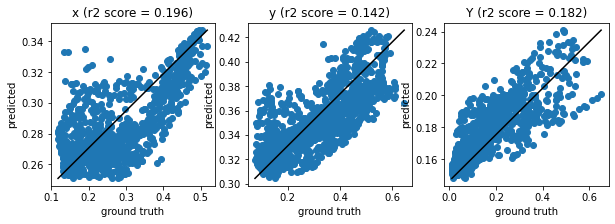

In [5]:
forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained.pth')['model_state_dict'])
inverse_model = MLP(3, 4).to(DEVICE)
inverse_model.load_state_dict(torch.load('./models/inverse_model_trained.pth')['model_state_dict'])
cie_raw, param_raw, cie_pred, param_pred = evaluate_simple_inverse(forward_model, inverse_model, test_loader.dataset)

plot_cie_raw_pred(cie_raw, cie_pred)
plt.show()


### Tandem (fixed decoder)

Tandem net Design RMSE loss 2.042
Tandem Design RMSE loss 138.686
Reconstruct RMSE loss 0.149
Reconstruct RMSE loss raw 0.019


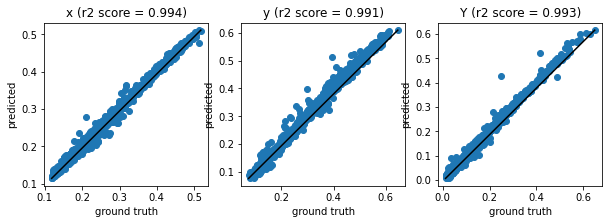

In [6]:
tandem_model = TandemNet(forward_model, inverse_model)
tandem_model.load_state_dict(torch.load('./models/tandem_net_trained.pth')['model_state_dict'])
cie_raw, param_raw, cie_pred, param_pred = evaluate_tandem_accuracy(tandem_model, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)


tensor([  0.4148,   0.5652,   0.6345, 170.0000, 160.0000, 400.0000,  80.0000],
       dtype=torch.float64) tensor([1.1840e-01, 7.6122e-02, 1.1448e-02, 3.0000e+01, 1.6000e+02, 3.0000e+02,
        8.0000e+01], dtype=torch.float64)
Simple net Design RMSE loss 1.176
Simple net RMSE loss 282.817
Reconstruct RMSE loss 0.492
Reconstruct RMSE loss raw 0.263


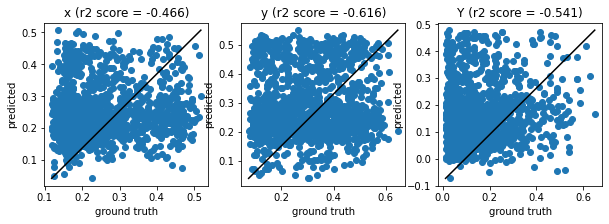

In [3]:
forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained.pth')['model_state_dict'])

# GSNN
configs = get_configs('vae_GSNN')
vae_model = cVAE_GSNN(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_GSNN_trained.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)


### VAE

tensor([  0.4148,   0.5652,   0.6345, 170.0000, 160.0000, 400.0000,  80.0000],
       dtype=torch.float64) tensor([1.1840e-01, 7.6122e-02, 1.1448e-02, 3.0000e+01, 1.6000e+02, 3.0000e+02,
        8.0000e+01], dtype=torch.float64)
Simple net Design RMSE loss 0.397
Simple net RMSE loss 93.092
Reconstruct RMSE loss 0.155
Reconstruct RMSE loss raw 0.086


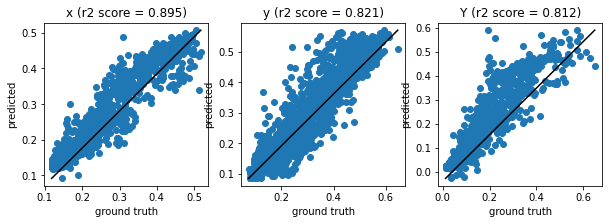

tensor([  0.4148,   0.5652,   0.6345, 170.0000, 160.0000, 400.0000,  80.0000],
       dtype=torch.float64) tensor([1.1840e-01, 7.6122e-02, 1.1448e-02, 3.0000e+01, 1.6000e+02, 3.0000e+02,
        8.0000e+01], dtype=torch.float64)
Simple net Design RMSE loss 0.385
Simple net RMSE loss 89.921
Reconstruct RMSE loss 0.156
Reconstruct RMSE loss raw 0.085


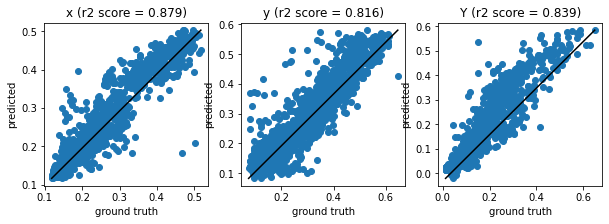

In [4]:
forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained.pth')['model_state_dict'])

# min-max pure laten dimension 5
configs = get_configs('vae')
configs['latent_dim'] = 5
vae_model = cVAE(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_trained_minmax_5.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

# min-max pure laten dimension 1
configs = get_configs('vae')
configs['latent_dim'] = 1
vae_model = cVAE(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_trained_minmax_1.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

tensor([  0.4148,   0.5652,   0.6345, 170.0000, 160.0000, 400.0000,  80.0000],
       dtype=torch.float64) tensor([1.1840e-01, 7.6122e-02, 1.1448e-02, 3.0000e+01, 1.6000e+02, 3.0000e+02,
        8.0000e+01], dtype=torch.float64)
Simple net Design RMSE loss 0.385
Simple net RMSE loss 89.670
Reconstruct RMSE loss 0.150
Reconstruct RMSE loss raw 0.083


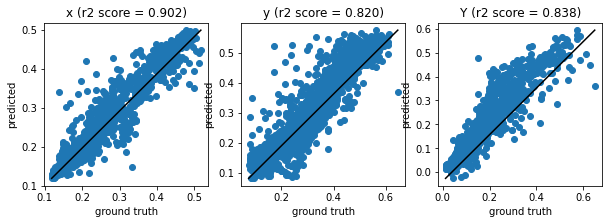

In [5]:
# min-max pure laten dimension 2
configs = get_configs('vae')
configs['latent_dim'] = 2
vae_model = cVAE(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_trained_minmax_2.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

tensor([  0.4148,   0.5652,   0.6345, 170.0000, 160.0000, 400.0000,  80.0000],
       dtype=torch.float64) tensor([1.1840e-01, 7.6122e-02, 1.1448e-02, 3.0000e+01, 1.6000e+02, 3.0000e+02,
        8.0000e+01], dtype=torch.float64)
Simple net Design RMSE loss 0.385
Simple net RMSE loss 89.822
Reconstruct RMSE loss 0.163
Reconstruct RMSE loss raw 0.089


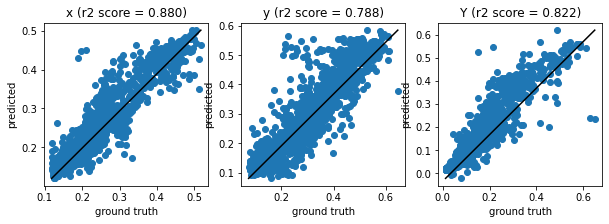

In [6]:
# min-max pure laten dimension 3
configs = get_configs('vae')
configs['latent_dim'] = 3
vae_model = cVAE(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_trained_minmax_3.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

tensor([  0.4148,   0.5652,   0.6345, 170.0000, 160.0000, 400.0000,  80.0000],
       dtype=torch.float64) tensor([1.1840e-01, 7.6122e-02, 1.1448e-02, 3.0000e+01, 1.6000e+02, 3.0000e+02,
        8.0000e+01], dtype=torch.float64)
Simple net Design RMSE loss 0.400
Simple net RMSE loss 93.009
Reconstruct RMSE loss 0.172
Reconstruct RMSE loss raw 0.093


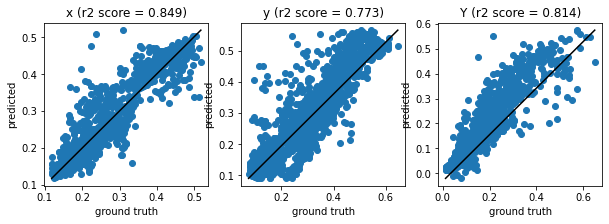

In [7]:
# min-max new laten dimension 5
configs = get_configs('vae_new')
configs['latent_dim'] = 5
vae_model = cVAE_new(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_trained_minmax_new_5.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

tensor([  0.4148,   0.5652,   0.6345, 170.0000, 160.0000, 400.0000,  80.0000],
       dtype=torch.float64) tensor([1.1840e-01, 7.6122e-02, 1.1448e-02, 3.0000e+01, 1.6000e+02, 3.0000e+02,
        8.0000e+01], dtype=torch.float64)
Simple net Design RMSE loss 0.393
Simple net RMSE loss 93.084
Reconstruct RMSE loss 0.164
Reconstruct RMSE loss raw 0.089


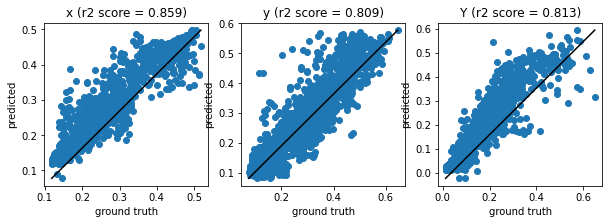

In [8]:
# min-max new predicted laten dimension 5
configs = get_configs('vae_new')
configs['latent_dim'] = 5
vae_model = cVAE_new(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_trained.minmax_new_5_preducted.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

### GAN


Simple net Design RMSE loss 2.797
Simple net RMSE loss 181.371
Reconstruct RMSE loss 1.599
Reconstruct RMSE loss raw 0.195


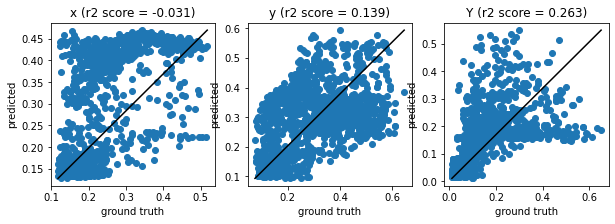

In [12]:
configs = get_configs('gan')
cgan = cGAN(3, 4, noise_dim = configs['noise_dim'], hidden_dim = 128).to(DEVICE)
cgan.load_state_dict(torch.load('./models/gan_trained.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_gan_inverse(forward_model, cgan, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)


### Inverse neural network

Simple net Design RMSE loss 1.790
Simple net RMSE loss 115.693
Reconstruct RMSE loss 0.577
Reconstruct RMSE loss raw 0.072


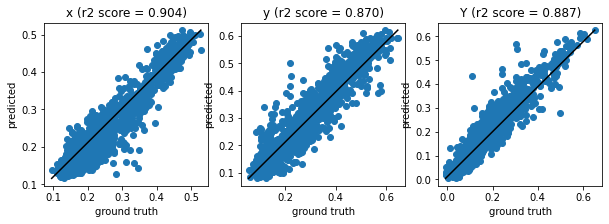

Simple net Design RMSE loss 1.904
Simple net RMSE loss 123.560
Reconstruct RMSE loss 0.571
Reconstruct RMSE loss raw 0.071


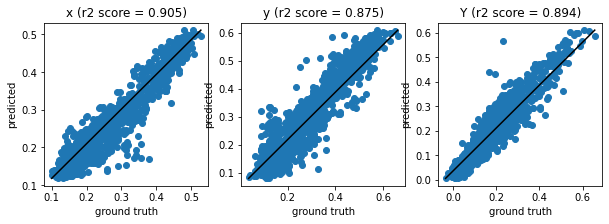

In [22]:
configs = get_configs('inn')
model = INN(configs['ndim_total'], configs['input_dim'], configs['output_dim'], dim_z = configs['latent_dim']).to(DEVICE)
model.load_state_dict(torch.load('./models/inn_trained.pth')['model_state_dict'], strict=False)

cie_raw, param_raw, cie_pred, param_pred = evaluate_inn_inverse(forward_model, model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

configs = get_configs('inn')
model = INN(configs['ndim_total'], configs['input_dim'], configs['output_dim'], dim_z = configs['latent_dim']).to(DEVICE)
model.load_state_dict(torch.load('./models/inn_trained_mustafa.pth')['model_state_dict'], strict=False)

cie_raw, param_raw, cie_pred, param_pred = evaluate_inn_inverse(forward_model, model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)
